> May 06, 2024 | {sub-ref}`wordcount-minutes` min read

::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 1000px
:align: left
::::



Authors:
* Irais Bautista ([CESGA](http://www.cesga.es)), Sergio Martínez ([BIFi-UNIZAR](https://bifi.es/es/)), Jaime Scharfhausen ([UAM](https://www.uam.es/uam/inicio)) y Alejandro Jaramillo ([CSUC](https://www.csuc.cat/es))

<img src="https://quantumspain-project.es/wp-content/uploads/2022/11/CESGA.png" width="100px">
<img src="http://bifi.es/wp-content/uploads/2016/11/logo_vectorial-web.png" width="200px">
<img src="https://www.iib.uam.es/iiblf6theme-theme/images/custom/logo-uam.png" width = "200px">
<img src="https://www.csuc.cat/sites/default/files/2021-02/CSUC_logo_corporatiu_0.png" width = "200px">

In [1]:
# General libraries
from utils.hamiltonian_utils import ising_chain_ham
from utils.rotosolve_optimizer import Rotosolve
from scipy.ndimage import gaussian_filter
import json
from styles.style import qspain
from IPython.display import Latex
from IPython import display
import matplotlib.pyplot as plt
import warnings
from qiskit_ibm_provider import IBMProvider as IBMQ

# Pennylane libraries
import pennylane as qml
from pennylane import numpy as np
from utils.pennylane_utils import print_pennylane_circuit, convert_vqe_to_dict

warnings.filterwarnings("ignore")
%matplotlib inline

(sec_Algoritmo_de_optimización_Rotosolve)= 
# Algoritmo de optimización Rotosolve

:::{contents}
:local:
:depth: 1
:::


(sec_Fundamento_teórico_del_optimizador_Rotosolve)= 
## Fundamento teórico del optimizador Rotosolve

El algoritmo de optimización <b>Rotosolve</b> es un algoritmo <i>quantum-aware</i>, ya que dicho algoritmo esta optimizado para obtener las mejores resultados sobre hardware de ordenadores cuánticos.


Este algoritmo de optimización es uno más de los posibles algoritmos que se pueden usar en circuitos variacionales (parametrizados) cuánticos. En esencia, el optimizador Rotosolve minimiza una función objetivo con respecto a los parámetros de un circuito cuántico sin necesidad de calcular el gradiente de la función. El algoritmo realiza iteraciones en los que actualiza los parámetros del circuito $\theta = \theta_1, \dots, \theta_D$ con la función de coste hasta completar el número máximo de iteraciones.


Este algoritmo de optimización hace descender el valor inicial de manera drástica, alcanzando el valor mínimo en pocas iteraciones.

El algoritmo <b>Rotosolve</b>{cite}`bib_jtilly_variational_2022`,{cite}`bib_mostaszewski_variational_2021`,{cite}`bib_jvidal_parameterized_2018`,{cite}`bib_dwierichs_parameter_2022` actúa de la siguiente forma, toma una puerta parametrizada de nuestro circuito de función de onda (<i>ansatz</i>) y ajusta su ángulo y dirección de rotación para obtener el valor de mínima energía. Este proceso se realiza iterativamente con cada una de las puertas parametrizadas, una vez el algoritmo de optimización ajusta la última puerta parametrizada repite el proceso hasta converger al valor mínimo. 

Consideremos un problema de optimización donde la función objetivo es un operador hermítico $M$ y la solución candidata se codifica en un circuito cuántico parametrizado $U = U_D \dots U_1$ que actúa sobre un estado inicial $\rho$ de n-qubits.


Cada puerta del circuito esta parametrizada de la forma $\text{exp}(-i\frac{\theta_d}{2}H_d)$, donde el ángulo de rotación $\theta \in (-\pi, \pi]$ y donde $H_d$ son matrices <b>unitarias</b> y <b>hermíticas</b>. Con todo ello, y sin pérdida de generalidad, minimizaremos la función objetivo a la que simplemente nos referiremos a ella como <i>la energía</i>. Matemáticamente, podemos plantear el problema como: 

$$
(\theta^{\ast}, H^{\ast}) = \argmin_{\theta, H}\ {\langle{H}\rangle}_{\theta, H},\ \text{donde}\ {\langle{H}\rangle}_{\theta, H} = tr(MU\rho U^\dagger)
$$

Disponemos de dos formas de solucionar el planteamiento matemático, una primera forma en la que optimizamos los ángulos de las puertas parametrizadas dejando invariante al circuito y una segunda forma en la que optimizamos simultaneamente el circuito y los ángulos de las puertas parametrizadas, esta última solución se denomina <b>Rotoselect</b>.


Rotoselect hace uso del algoritmo Rotosolve para obtener el valor óptimo del ángulo de cada una de las puertas parametrizadas. 


Seleccionaremos la primera opción expuesta por ser la solución usada en el algoritmo <b>Rotosolve</b>.

En la primera solución (Rotosolve), tomamos el ángulo de la primera puerta para su optimización dejando las demás puertas fijas, de tal manera que este proceso se repite de forma secuencial pasando por todas las puertas parametrizadas. Esto es bastante simple de realizar ya que en cada paso secuencial la energía tiene una forma sinusoidal con un periodo de $2\pi$. Por ejemplo, para la puerta $U_d$ el ángulo óptimo se calcula de la siguiente forma: 


$$
\begin{align*}
\theta_{d}^* &= \argmin_{\theta_d} {\langle{M}\rangle}_{\theta_d} = \phi - \tfrac{\pi}{2} - \text{arctan2}\big(2{\langle{M}\rangle}_{\phi} - {\langle{M}\rangle}_{\phi+\frac{\pi}{2}} - {\langle{M}\rangle}_{\phi-\frac{\pi}{2}} , ~ {\langle{M}\rangle}_{\phi+\frac{\pi}{2}} - {\langle{M}\rangle}_{\phi-\frac{\pi}{2}} \big) + 2\pi k
\end{align*}
$$


Esta expresión se cumple para cualquier número real $\phi$ y cualquier número entero $k$. En la práctica seleccionamos un valor de $k$ tal que $\theta_d^* \in (-\pi, \pi]$.


El ángulo óptimo se puede encontrar para todo $d = 1, \dots D$ hasta completar el ciclo de puertas parametrizadas. Una vez todos los ángulos se han actualizado, se inicia un nuevo ciclo de optimización a menos que se cumpla un cierto criterio de parada.

(sec_Modelo_de_Ising_1D_con_optimizador_Rotosolve)= 
## Modelo de Ising 1D con optimizador Rotosolve

Para ejemplificar el algoritmo de optimización Rotosolve, tomaremos el mismo Hamiltoniano del Modelo de Ising 1D descrito en el <i>notebook</i> de <a href="../Chapter_01_Introduction.ipynb#sec_El_Modelo_de_Ising_con_el_algoritmo_VQE">Introducción al algoritmo VQE</a>, usaremos el mismo número de espínes ($n = 4$) y el mismo valor de $\gamma = 0.3$: 

$$
\mathcal{H} = X_1X_2I_3I_4 + I_1X_2X_3I_4 + I_1I_2X_3X_4 + X_1I_2I_3X_4 + \gamma (Z_1I_2I_3I_4 + I_1Z_2I_3I_4 + I_1I_2Z_3I_4 + I_1I_2I_3Z_4)
$$


En este caso usaremos el algoritmo de optimización <b>Rotosolve</b> y compararemos los resultados con el valor obtenido con anterioridad en el <i>notebook</i> de <a href="../Chapter_01_Introduction.ipynb#sec_El_Modelo_de_Ising_con_el_algoritmo_VQE">Introducción al algoritmo VQE</a>.

Codificamos el hamiltoniano en Qiskit como un operador y preparamos un ansatz TwoLocal ya implementado en esta librería.

(sec_Rotosolve_con_Pennylane)= 
## Rotosolve con Pennylane

Como alternativa a Qiskit, tenemos <b>Pennylane</b>. Es una librería de programación muy enfocada a <i>Quantum Machine Learning</i>.


Vamos a intentar reproducir lo que hemos realizado anteriormente en Qiskit, veremos si obtenemos una energía menor para nuestro Hamiltoniano.


Creamos un operador con nuestro Hamiltaniano que sea compatible con Pennylane. 

:::::{tab-set}
::::{tab-item} Pennylane
```python

# Definimos el Hamiltoniano
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham(n, gam, pennylane = True) # Creamos el Hamiltoniano descrito
#H = qml.Hamiltonian(H.coeffs, H.ops)
print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------\n")
print(H)
```
::::
:::::


In [2]:
'''Pennylane_code_cell'''

# Definimos el Hamiltoniano
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham(n, gam, pennylane = True) # Creamos el Hamiltoniano descrito
#H = qml.Hamiltonian(H.coeffs, H.ops)
print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------\n")
print(H)

Estructura del Hamiltoniano en matrices de Pauli:
--------------------------------------------------

  (0.29999999999999993) [I0 Z1 I2 I3]
+ (0.29999999999999993) [Z0 I1 I2 I3]
+ (0.3) [I0 I1 I2 Z3]
+ (0.3) [I0 I1 Z2 I3]
+ (1.0) [I0 I1 X2 X3]
+ (1.0) [I0 X1 X2 I3]
+ (1.0) [X0 I1 I2 X3]
+ (1.0) [X0 X1 I2 I3]


Vamos a crear un circuito parametrizado como ansatz, usaremos cuatro qubits que entrelazaremos y daremos un valor inicial, al ejecutarlo con el optimizador **Rotosolve** los valores se optimizarán haciendo que el sistema converja a la energía mínima. 

:::::{tab-set}
::::{tab-item} Pennylane
```python

dev = qml.device("lightning.qubit", wires = n) # pennylane simulator

init_param = (
    np.array(np.random.random(n), requires_grad=True),
    np.array(1.1, requires_grad=True),
    np.array(np.random.random(n), requires_grad=True),
)

rot_weights = np.ones(n)
crot_weights = np.ones(n)

nums_frequency = {
    "rot_param": {(0,): 1, (1,): 1, (2,): 1., (3,): 1.}, # parámetros iniciales para las rotaciones de puertas
    "layer_par": {(): n},
    "crot_param": {(0,): 2, (1,): 2, (2,): 2, (3,): 2},
}

@qml.qnode(dev)
def ansatz(rot_param, layer_par, crot_param, rot_weights = None, crot_weights = None):
    
    # Ansatz
    # la selección del ansatz impacta en el cómputo de la solución. Se debe probar qué ansatz es mejor en cada caso
    for i, par in enumerate(rot_param * rot_weights):
        qml.RY(par, wires = i)
            
    for _ in list(range(len(dev.wires))):

        qml.CNOT(wires = [0, 1])
        qml.CNOT(wires = [0, 2])
        qml.CNOT(wires = [1, 2])
        qml.CNOT(wires = [0, 3])
        qml.CNOT(wires = [1, 3])
        qml.CNOT(wires = [2, 3])
        
    # Medimos el valor esperado del Hamiltoniano
    return qml.expval(H)
```
::::
:::::


In [3]:
'''Pennylane_code_cell'''

dev = qml.device("lightning.qubit", wires = n) # pennylane simulator

init_param = (
    np.array(np.random.random(n), requires_grad=True),
    np.array(1.1, requires_grad=True),
    np.array(np.random.random(n), requires_grad=True),
)

rot_weights = np.ones(n)
crot_weights = np.ones(n)

nums_frequency = {
    "rot_param": {(0,): 1, (1,): 1, (2,): 1., (3,): 1.}, # parámetros iniciales para las rotaciones de puertas
    "layer_par": {(): n},
    "crot_param": {(0,): 2, (1,): 2, (2,): 2, (3,): 2},
}

@qml.qnode(dev)
def ansatz(rot_param, layer_par, crot_param, rot_weights = None, crot_weights = None):
    
    # Ansatz
    # la selección del ansatz impacta en el cómputo de la solución. Se debe probar qué ansatz es mejor en cada caso
    for i, par in enumerate(rot_param * rot_weights):
        qml.RY(par, wires = i)
            
    for _ in list(range(len(dev.wires))):

        qml.CNOT(wires = [0, 1])
        qml.CNOT(wires = [0, 2])
        qml.CNOT(wires = [1, 2])
        qml.CNOT(wires = [0, 3])
        qml.CNOT(wires = [1, 3])
        qml.CNOT(wires = [2, 3])
        
    # Medimos el valor esperado del Hamiltoniano
    return qml.expval(H)

Mostramos el circuito que usamos como ansatz.

:::::{tab-set}
::::{tab-item} Pennylane
```python

# https://docs.pennylane.ai/en/stable/code/api/pennylane.draw_mpl.html
# Dibujamos el circuito con pennylane
fig, _ = qml.draw_mpl(ansatz, style="default", fontsize = "medium")(*init_param, rot_weights = rot_weights, crot_weights = crot_weights)
fig.show()
```
::::
:::::


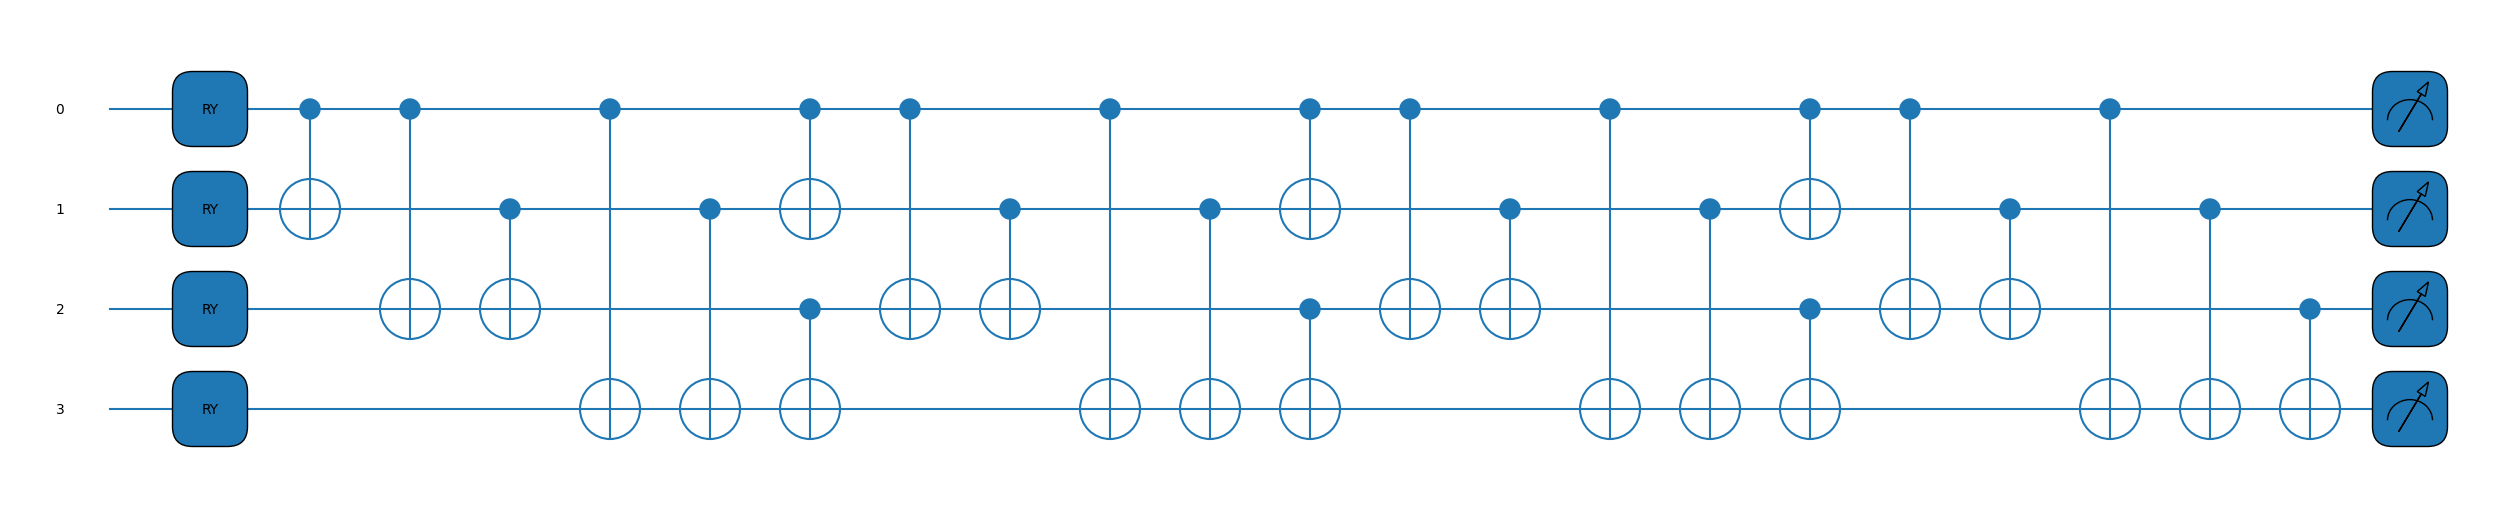

In [4]:
'''Pennylane_code_cell'''

# https://docs.pennylane.ai/en/stable/code/api/pennylane.draw_mpl.html
# Dibujamos el circuito con pennylane
fig, _ = qml.draw_mpl(ansatz, style="default", fontsize = "medium")(*init_param, rot_weights = rot_weights, crot_weights = crot_weights)
fig.show()

:::::{tab-set}
::::{tab-item} Pennylane
```python

# Incluye aquí el token personal de ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

# Configuración de ejecución
CONFIGURATION = {
    'USE_REAL_BACKEND_NOISE': False, # Usa o no el backend real de ibmq_lima para obtener el ruido del dispositivo para la simulacion VQE
    'JSON_RESULT': True, # Usa los resultados obtenidos de una ejecución previa del algoritmo VQE en el dispositivo real ibmq_lima, desactivar esta opción puede hacer que la ejecución de VQE tarde horas
}
```
::::
:::::


In [5]:
'''Pennylane_code_cell'''

# Incluye aquí el token personal de ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

# Configuración de ejecución
CONFIGURATION = {
    'USE_REAL_BACKEND_NOISE': False, # Usa o no el backend real de ibmq_lima para obtener el ruido del dispositivo para la simulacion VQE
    'JSON_RESULT': True, # Usa los resultados obtenidos de una ejecución previa del algoritmo VQE en el dispositivo real ibmq_lima, desactivar esta opción puede hacer que la ejecución de VQE tarde horas
}

:::::{tab-set}
::::{tab-item} Pennylane
```python

if not CONFIGURATION['JSON_RESULT']:

    max_iterations = 500 # número de iteraciones de rotosolve
    
    # Usamos el optimizadpr Rotosolve que viene implementado en Pennylane
    opt = qml.RotosolveOptimizer(substep_optimizer = "brute", substep_kwargs = {"num_steps": 4})
    
    param = init_param
    
    rot_weights = np.array([0.4, 0.8, 1.0, 1.2], requires_grad=False)
    crot_weights = np.array([0.5, 1.0, 1.5, 1.8], requires_grad=False)
    
    cost_rotosolve = []
    
    for n in range(max_iterations):
    
        param, cost, prev_energy = opt.step_and_cost(
             ansatz,
             *param,
             nums_frequency=nums_frequency,
             spectra = [],
             full_output=True,
             rot_weights=rot_weights,
             crot_weights=crot_weights,
        )
    
        # Compute energy
        energy = ansatz(*param, rot_weights=rot_weights, crot_weights=crot_weights)
    
        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)
        
        if n % 10 == 0:
            print("Iteration = {:},  Energy = {:.15f} Ha,  Convergence parameter = {:.15f} Ha".format(n, energy, np.mean(conv)))
    
        cost_rotosolve.extend(prev_energy)
    
    print("\n==================================")
    print("Number of iterations = ", max_iterations)
    print("Last energy value = ", cost_rotosolve[len(cost_rotosolve) - 1])
else:
    
    with open('./utils/results/vqe-rotosolve-pennylane.json') as user_file:
            json_dict = user_file.read()
    
    cost_rotosolve = json.loads(json_dict)
```
::::
:::::


In [6]:
'''Pennylane_code_cell'''

if not CONFIGURATION['JSON_RESULT']:

    max_iterations = 500 # número de iteraciones de rotosolve
    
    # Usamos el optimizadpr Rotosolve que viene implementado en Pennylane
    opt = qml.RotosolveOptimizer(substep_optimizer = "brute", substep_kwargs = {"num_steps": 4})
    
    param = init_param
    
    rot_weights = np.array([0.4, 0.8, 1.0, 1.2], requires_grad=False)
    crot_weights = np.array([0.5, 1.0, 1.5, 1.8], requires_grad=False)
    
    cost_rotosolve = []
    
    for n in range(max_iterations):
    
        param, cost, prev_energy = opt.step_and_cost(
             ansatz,
             *param,
             nums_frequency=nums_frequency,
             spectra = [],
             full_output=True,
             rot_weights=rot_weights,
             crot_weights=crot_weights,
        )
    
        # Compute energy
        energy = ansatz(*param, rot_weights=rot_weights, crot_weights=crot_weights)
    
        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)
        
        if n % 10 == 0:
            print("Iteration = {:},  Energy = {:.15f} Ha,  Convergence parameter = {:.15f} Ha".format(n, energy, np.mean(conv)))
    
        cost_rotosolve.extend(prev_energy)
    
    print("\n==================================")
    print("Number of iterations = ", max_iterations)
    print("Last energy value = ", cost_rotosolve[len(cost_rotosolve) - 1])
else:
    
    with open('./utils/results/vqe-rotosolve-pennylane.json') as user_file:
            json_dict = user_file.read()
    
    cost_rotosolve = json.loads(json_dict)

Creamos una gráfica con los resultados de convergencia de la energía.

:::::{tab-set}
::::{tab-item} Pennylane
```python

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(cost_rotosolve)), cost_rotosolve, label="Energy value real", color='red')
plt.plot(range(len(cost_rotosolve)), smooth(cost_rotosolve), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


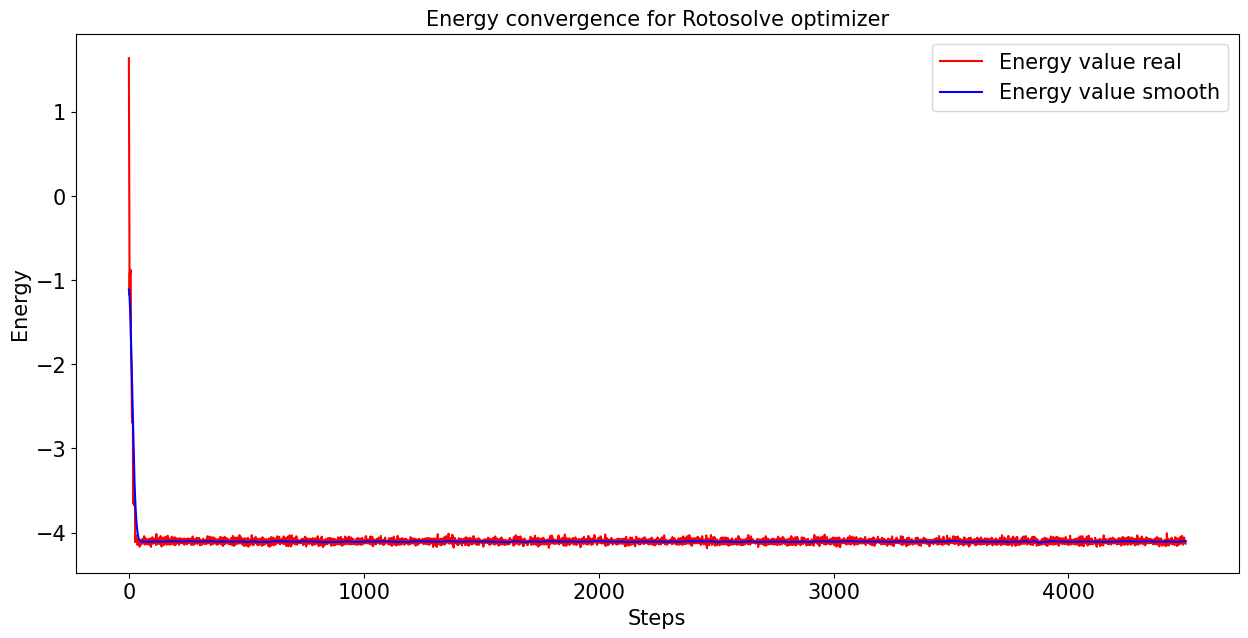

In [7]:
'''Pennylane_code_cell'''

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(cost_rotosolve)), cost_rotosolve, label="Energy value real", color='red')
plt.plot(range(len(cost_rotosolve)), smooth(cost_rotosolve), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

Hemos obtenido una gran sorpresa🎉🎊, la energía del Hamiltoniano que hemos obtenido con Pennylane es menor que la obtenida con Qiskit, en éste caso la selección del ansatz ha sido clave para obtener una mejora en la energía.


- El valor de la energía mínima es aprox.: <b>-4.116020151675932</b>

(sec_Ansatz_en_hardware_real)= 
### Ansatz en hardware real

Pennylane también tiene plantillas para realizar el circuito de ansatz, a continuación vamos a usar un par de ellas a modo de ejemplo.


Vamos a enviar el circuito de Pennylane a un ordenador cuántico de IBM. Si deseamos usar el hardware de IBM debemos poner el token que encontraremos en nuestra cuenta de usuario de IBM Experience.

In [8]:
# Set your accout token here for ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

if QISKIT_TOKEN != "":
    IBMQ.save_account(QISKIT_TOKEN, overwrite=True)
    print("Token IBMQ guardado!")

    provider = IBMQ()
    print("Provider Instance: ", provider.active_account()['instance'])
    print("Provider Channel: ", provider.active_account()['channel'])
#else:
#    pass # Skip token check
#    raise("Token no encontrado. Regístrate en https://quantum-computing.ibm.com/ para obtener el token y usar un backend real")

Creamos un operador con nuestro Hamiltoniano listo para usar en Pennylane con operadores de Pauli.

:::::{tab-set}
::::{tab-item} Pennylane
```python

# Definimos el Hamiltoniano
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham(n, gam, pennylane = True) # Creamos el Hamiltoniano descrito

print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------\n")
print(H)
```
::::
:::::


In [9]:
'''Pennylane_code_cell'''

# Definimos el Hamiltoniano
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham(n, gam, pennylane = True) # Creamos el Hamiltoniano descrito

print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------\n")
print(H)

Estructura del Hamiltoniano en matrices de Pauli:
--------------------------------------------------

  (0.29999999999999993) [I0 Z1 I2 I3]
+ (0.29999999999999993) [Z0 I1 I2 I3]
+ (0.3) [I0 I1 I2 Z3]
+ (0.3) [I0 I1 Z2 I3]
+ (1.0) [I0 I1 X2 X3]
+ (1.0) [I0 X1 X2 I3]
+ (1.0) [X0 I1 I2 X3]
+ (1.0) [X0 X1 I2 I3]


Ahora creamos el ansatz con el estilo Pennylane, realizamos un circuito de puertas parametrizadas a las que les daremos un valor inicial y seguidamente con optimizaremos su valor. 

:::::{tab-set}
::::{tab-item} Pennylane
```python

def ansatz_backend(params):

    wires = int(params[4])
    rot_param = np.array(params[0:4])
    rot_weights = np.array(params[5:])
    
    for i, par in enumerate(rot_param * rot_weights):
        qml.RY(par, wires = i)
            
    for _ in list(range(wires)):
       
        qml.CNOT(wires = [0, 1])
        qml.CNOT(wires = [0, 2])
        qml.CNOT(wires = [1, 2])
        qml.CNOT(wires = [0, 3])
        qml.CNOT(wires = [1, 3])
        qml.CNOT(wires = [2, 3])
```
::::
:::::


In [10]:
'''Pennylane_code_cell'''

def ansatz_backend(params):

    wires = int(params[4])
    rot_param = np.array(params[0:4])
    rot_weights = np.array(params[5:])
    
    for i, par in enumerate(rot_param * rot_weights):
        qml.RY(par, wires = i)
            
    for _ in list(range(wires)):
       
        qml.CNOT(wires = [0, 1])
        qml.CNOT(wires = [0, 2])
        qml.CNOT(wires = [1, 2])
        qml.CNOT(wires = [0, 3])
        qml.CNOT(wires = [1, 3])
        qml.CNOT(wires = [2, 3])

El circuito que hemos creado es el siguiente:

:::::{tab-set}
::::{tab-item} Pennylane
```python

rot_weights = np.array([0.4, 0.8, 1.0, 1.2], requires_grad=False)
crot_weights = np.array([0.5, 1.0, 1.5, 1.8], requires_grad=False)

n_wires = 4
init_param = [*np.array(np.random.random(n_wires), requires_grad=True), n_wires, *np.array(np.random.random(4), requires_grad=True)]

print_pennylane_circuit(ansatz_backend, init_param, n_wires, qiskit = True, qsstyle = True)
```
::::
:::::


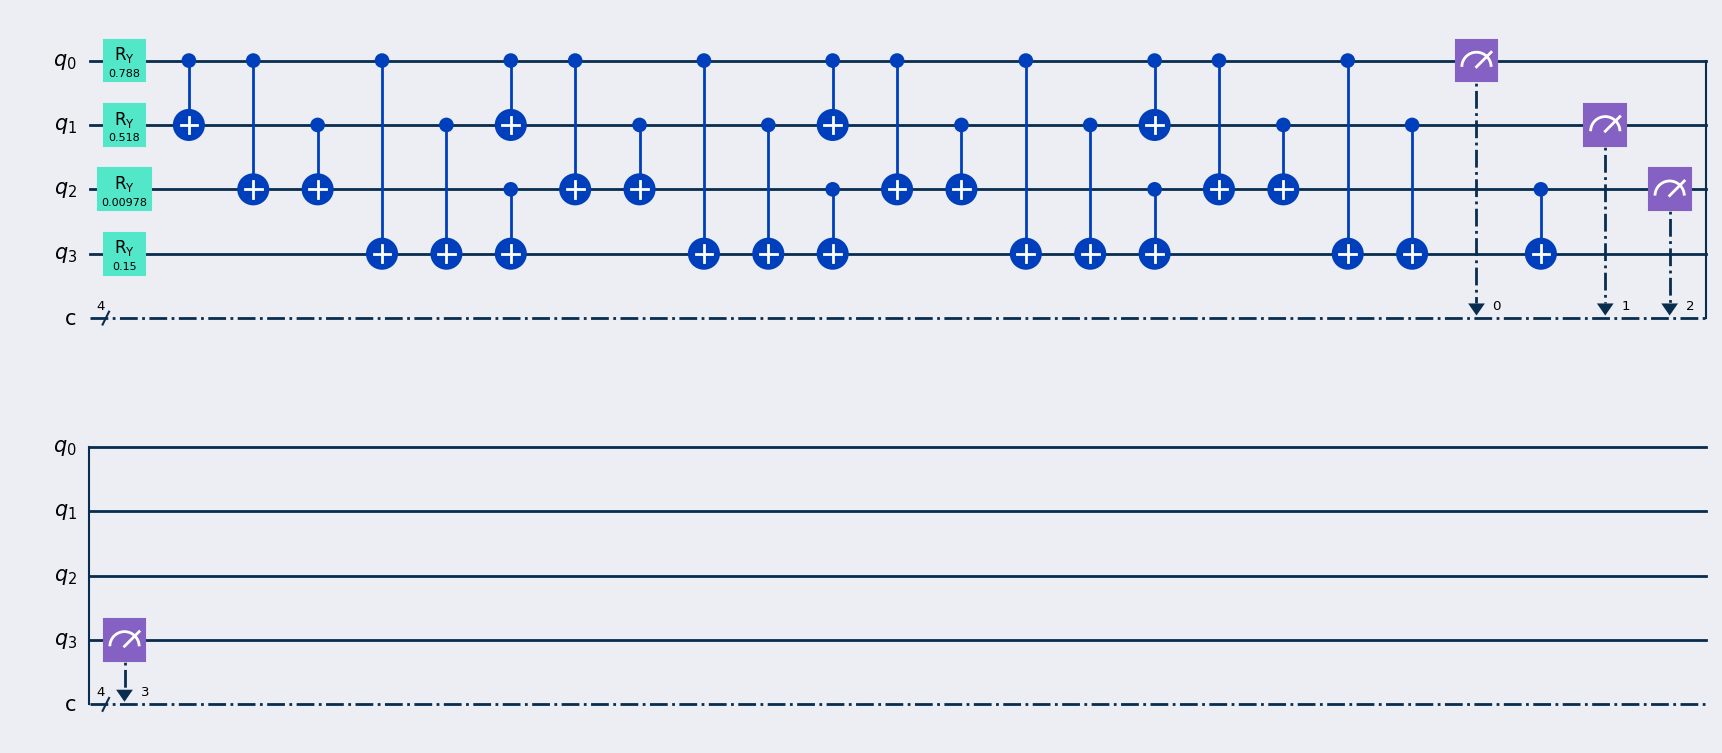

In [11]:
'''Pennylane_code_cell'''

rot_weights = np.array([0.4, 0.8, 1.0, 1.2], requires_grad=False)
crot_weights = np.array([0.5, 1.0, 1.5, 1.8], requires_grad=False)

n_wires = 4
init_param = [*np.array(np.random.random(n_wires), requires_grad=True), n_wires, *np.array(np.random.random(4), requires_grad=True)]

print_pennylane_circuit(ansatz_backend, init_param, n_wires, qiskit = True, qsstyle = True)

Enviar y hacer converger el circuito VQE de Pennylane en los ordenadores de IBM tarda un tiempo que depende del número de usuarios que estan usando ese ordenador, por ello podemos recuperar una ejecución anterior para acelerar el proceso.
<br/>
<br/>
Podemos enviar nuestros circuitos a un ordenador cuántico real de IBM, tanto nuestro código de descenso de gradiente simple que se muestra a continuación como nuestro código VQE con el optimizador de descenso de gradiente, el problema en ambos es que se trata de un proceso muy lento y por ello no es posible terminar una ejecución completa, por ello vamos a ejecutarlo con un simulador.

:::::{tab-set}
::::{tab-item} Pennylane
```python

RECOVER_RESULT = True

if RECOVER_RESULT:
    
    with open('./utils/results/vqe-runtime-V3kAkm9J2p.json') as js:
        data = json.load(js)
    
    results = data['intermediate_results']
    
else:

    num_qubits = 4
    init_param = [*np.array(np.random.random(num_qubits), requires_grad=True), n_wires, *np.array(np.random.random(4), requires_grad=True)]

    dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_osaka', ibmqx_token=QISKIT_TOKEN) # real device
    #dev = qml.device("lightning.qubit", wires = num_qubits) # pennylane simulator

    results = []

    def circuit(p):
        ansatz_backend(p)
        return qml.expval(H)

    cost_function = qml.QNode(circuit, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    params = init_param
    ntrials = 50

    for n in range(ntrials):
        params, new_energy = opt.step_and_cost(cost_function, params)

        print(f"--- Step: {n}, Energy: {new_energy:.12f}")
            
        results.append(new_energy)
```
::::
:::::


In [12]:
'''Pennylane_code_cell'''

RECOVER_RESULT = True

if RECOVER_RESULT:
    
    with open('./utils/results/vqe-runtime-V3kAkm9J2p.json') as js:
        data = json.load(js)
    
    results = data['intermediate_results']
    
else:

    num_qubits = 4
    init_param = [*np.array(np.random.random(num_qubits), requires_grad=True), n_wires, *np.array(np.random.random(4), requires_grad=True)]

    dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_osaka', ibmqx_token=QISKIT_TOKEN) # real device
    #dev = qml.device("lightning.qubit", wires = num_qubits) # pennylane simulator

    results = []

    def circuit(p):
        ansatz_backend(p)
        return qml.expval(H)

    cost_function = qml.QNode(circuit, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    params = init_param
    ntrials = 50

    for n in range(ntrials):
        params, new_energy = opt.step_and_cost(cost_function, params)

        print(f"--- Step: {n}, Energy: {new_energy:.12f}")
            
        results.append(new_energy)

In [13]:
print("Energía mínima:", np.min(results))

Energía mínima: -2.22177734375


Los resultados obtenidos podemos mostrarlos en una gráfica:

:::::{tab-set}
::::{tab-item} Pennylane
```python

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(results)), results, label="Energy value real", color='red')
plt.plot(range(len(results)), smooth(results), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


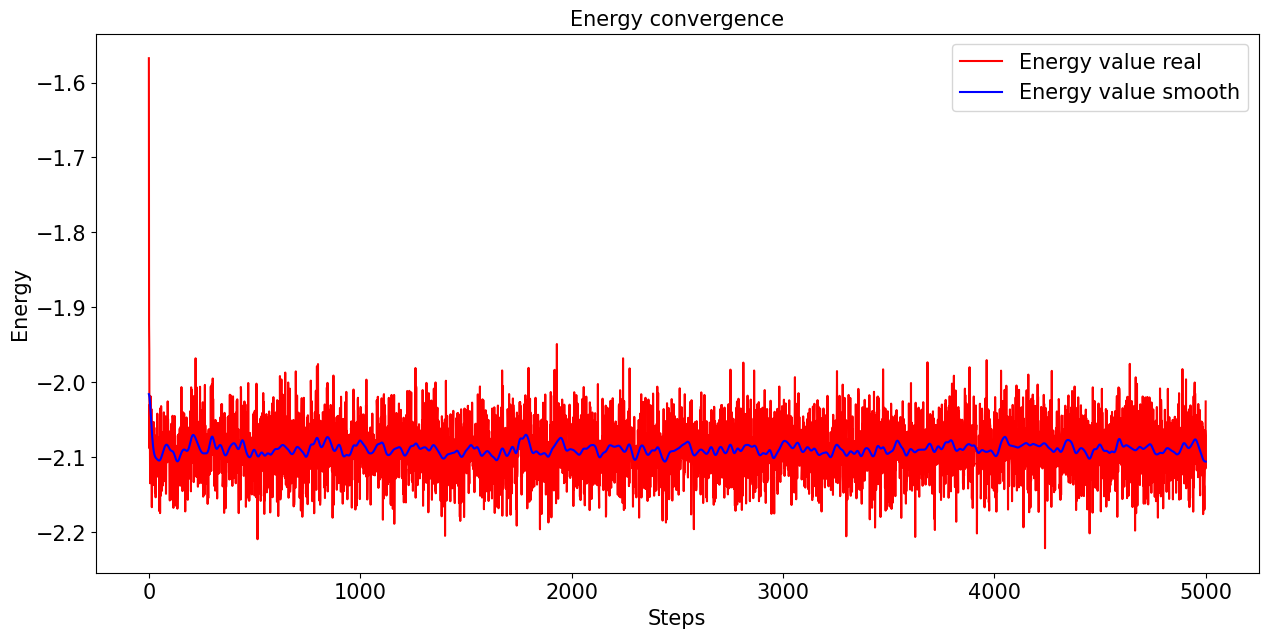

In [14]:
'''Pennylane_code_cell'''

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(results)), results, label="Energy value real", color='red')
plt.plot(range(len(results)), smooth(results), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

El resultado es bastante bueno, pero no todo lo bueno que podíamos esperar, podemos mojorarlo usando otro ansatz u otros valores iniciales para las puestas parametrizadas. Sin embargo, podemos ver como el sistema converge a un valor mínimo.

(sec_Plantilla_SimplifiedTwoDesign_ansatz_de_Pennylane)= 
#### Plantilla SimplifiedTwoDesign ansatz de Pennylane

El framework Pennylane también provee de plantillas para crear el ansatz, en este caso mostraremos como puede usarse en ansatz *SimplifiedTwoDesign*.
<br/>
<br/>
Este ansatz es un circuito parametrizado al que solo tenemos que darle el número de qubits y los valores iniciales, para más información consulta la [documentación de Pennylane](https://docs.pennylane.ai/en/stable/code/api/pennylane.SimplifiedTwoDesign.html).

:::::{tab-set}
::::{tab-item} Pennylane
```python

def ansatz_backend2(params):
    
    n_wires = int(params[len(params) - 1])
    
    init_weights = list(params[0:4])
    
    weights1 = np.array(np.array_split(params[4:10], 3))
    weights2 = np.array(np.array_split(params[10:16], 3))
    weights3 = np.array(np.array_split(params[16:22], 3))
    weights = np.array([weights1, weights2, weights3])
    
    # https://docs.pennylane.ai/en/stable/code/api/pennylane.SimplifiedTwoDesign.html
    qml.SimplifiedTwoDesign(initial_layer_weights = init_weights, weights = weights, wires = range(n_wires))


n_params = 22
n_wires = 4
init_params = []

for _ in list(range(n_params)):
    rnd_value = np.random.random(2).tolist()
    init_params.append(rnd_value[0])
    init_params.append(rnd_value[1])

init_params.append(n_wires)

print_pennylane_circuit(ansatz_backend2, init_params, n_wires, qiskit = False, qsstyle = False)
```
::::
:::::


:::::{tab-set}
::::{tab-item} Pennylane
```python

def ansatz_backend2(params):
    
    n_wires = int(params[len(params) - 1])
    
    init_weights = list(params[0:4])
    
    weights1 = np.array(np.array_split(params[4:10], 3))
    weights2 = np.array(np.array_split(params[10:16], 3))
    weights3 = np.array(np.array_split(params[16:22], 3))
    weights = np.array([weights1, weights2, weights3])
    
    # https://docs.pennylane.ai/en/stable/code/api/pennylane.SimplifiedTwoDesign.html
    qml.SimplifiedTwoDesign(initial_layer_weights = init_weights, weights = weights, wires = range(n_wires))


n_params = 22
n_wires = 4
init_params = []

for _ in list(range(n_params)):
    rnd_value = np.random.random(2).tolist()
    init_params.append(rnd_value[0])
    init_params.append(rnd_value[1])

init_params.append(n_wires)

print_pennylane_circuit(ansatz_backend2, init_params, n_wires, qiskit = False, qsstyle = False)
```
::::
:::::


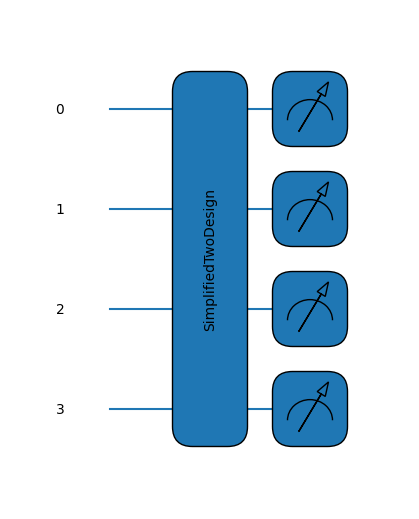

In [15]:
'''Pennylane_code_cell'''

def ansatz_backend2(params):
    
    n_wires = int(params[len(params) - 1])
    
    init_weights = list(params[0:4])
    
    weights1 = np.array(np.array_split(params[4:10], 3))
    weights2 = np.array(np.array_split(params[10:16], 3))
    weights3 = np.array(np.array_split(params[16:22], 3))
    weights = np.array([weights1, weights2, weights3])
    
    # https://docs.pennylane.ai/en/stable/code/api/pennylane.SimplifiedTwoDesign.html
    qml.SimplifiedTwoDesign(initial_layer_weights = init_weights, weights = weights, wires = range(n_wires))

'''Pennylane_code_cell'''

n_params = 22
n_wires = 4
init_params = []

for _ in list(range(n_params)):
    rnd_value = np.random.random(2).tolist()
    init_params.append(rnd_value[0])
    init_params.append(rnd_value[1])

init_params.append(n_wires)

print_pennylane_circuit(ansatz_backend2, init_params, n_wires, qiskit = False, qsstyle = False)

La ejecución en el backend de IBM tarda algún tiempo, por ello, usaremos los resultados de una ejecución anterior para analizar la convergencia del sistema.

:::::{tab-set}
::::{tab-item} Pennylane
```python

RECOVER_RESULT = True

if RECOVER_RESULT:
    
    with open('./utils/results/vqe-runtime-d3lj4Na0Wp.json') as js:
        data = json.load(js)
    
    results_ansatz2 = data['intermediate_results']
    
else:

    #dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_qasm_simulator', ibmqx_token=QISKIT_TOKEN) # real device
    dev = qml.device("lightning.qubit", wires = num_qubits) # pennylane simulator
    
    results = []

    def circuit(p):
        ansatz_backend2(p)
        return qml.expval(H)

    cost_function = qml.QNode(circuit, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    params = init_params
    ntrials = 50

    for n in range(ntrials):
        params, new_energy = opt.step_and_cost(cost_function, params)

        print(f"--- Step: {n}, Energy: {new_energy:.12f}")
            
        results.append(new_energy)
```
::::
:::::


In [16]:
'''Pennylane_code_cell'''

RECOVER_RESULT = True

if RECOVER_RESULT:
    
    with open('./utils/results/vqe-runtime-d3lj4Na0Wp.json') as js:
        data = json.load(js)
    
    results_ansatz2 = data['intermediate_results']
    
else:

    #dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_qasm_simulator', ibmqx_token=QISKIT_TOKEN) # real device
    dev = qml.device("lightning.qubit", wires = num_qubits) # pennylane simulator
    
    results = []

    def circuit(p):
        ansatz_backend2(p)
        return qml.expval(H)

    cost_function = qml.QNode(circuit, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    params = init_params
    ntrials = 50

    for n in range(ntrials):
        params, new_energy = opt.step_and_cost(cost_function, params)

        print(f"--- Step: {n}, Energy: {new_energy:.12f}")
            
        results.append(new_energy)

In [17]:
print("Energía mínima:", np.min(results_ansatz2))

Energía mínima: -2.949609375


:::::{tab-set}
::::{tab-item} Pennylane
```python

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(results_ansatz2)), results_ansatz2, label="Energy value real", color='red')
plt.plot(range(len(results_ansatz2)), smooth(results_ansatz2), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


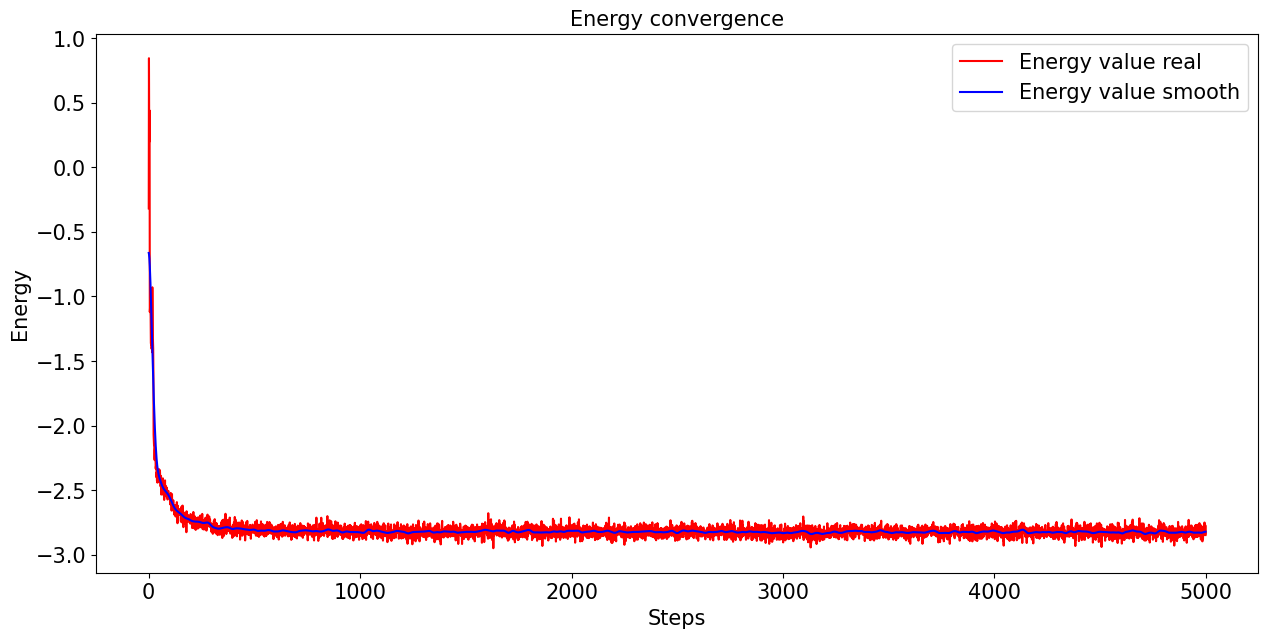

In [18]:
'''Pennylane_code_cell'''

def smooth(data):
    return gaussian_filter(data, sigma=10, mode='reflect', truncate=18.0)

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(results_ansatz2)), results_ansatz2, label="Energy value real", color='red')
plt.plot(range(len(results_ansatz2)), smooth(results_ansatz2), label="Energy value smooth", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

plt.title('Energy convergence', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

De nuevo, vemos que los resultados aunque son mejores con respecto al ansatz anterior, no son todo lo buenos que se puede obtener con otras técnicas, sin embargo, volvemos a ver como el sistema converge a un valor mínimo.

(sec_Más_ansatzë_de_Pennylane_template)= 
#### Más ansatzë de Pennylane template

Vamos a usar una última función de ansatz de catálogo que tiene incorporado Pennylane, en este caso usaremos *StronglyEntanglingLayers*, para más información consulta la [documentación de Pennylane](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html).
<br/>
<br/>
Se trata de un ansatz en el que todos los qubits estan entrelazados entre ellos mediante puertas CNOT y puertas parametrizadas.

:::::{tab-set}
::::{tab-item} Pennylane
```python

n_wires = 4

def ansatz_backend3(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(n_wires), ranges=range(1, n_wires), imprimitive=qml.ops.CZ)

shape = qml.StronglyEntanglingLayers.shape(n_layers=n_wires-1, n_wires=n_wires)
weights_entangled = np.random.random(size=shape)

print_pennylane_circuit(ansatz_backend3, weights_entangled, n_wires, qiskit = True, qsstyle = True)
```
::::
:::::


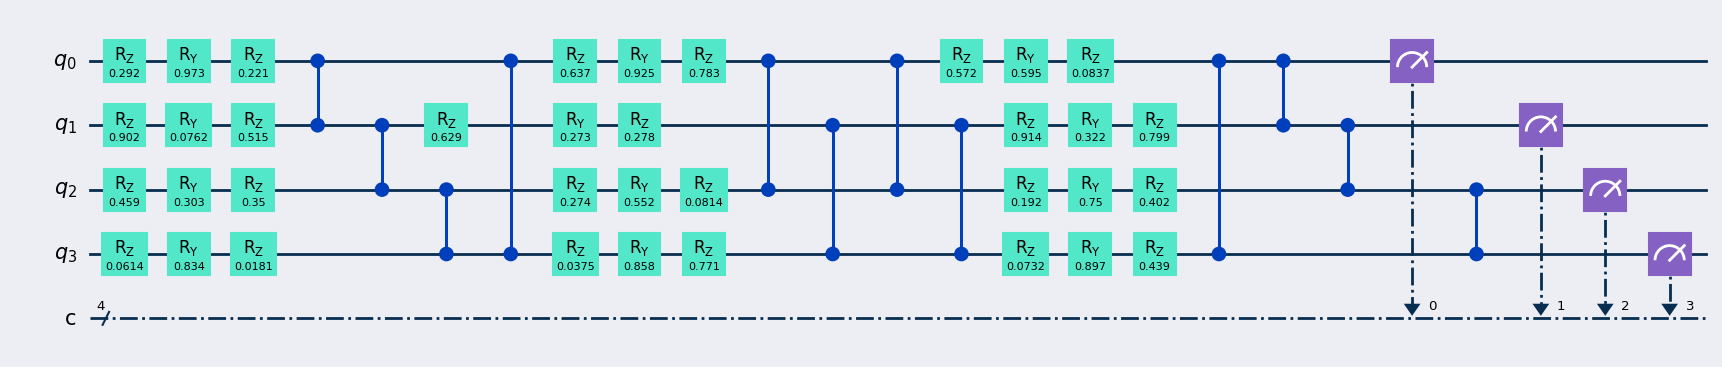

In [19]:
'''Pennylane_code_cell'''

n_wires = 4

def ansatz_backend3(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(n_wires), ranges=range(1, n_wires), imprimitive=qml.ops.CZ)

shape = qml.StronglyEntanglingLayers.shape(n_layers=n_wires-1, n_wires=n_wires)
weights_entangled = np.random.random(size=shape)

print_pennylane_circuit(ansatz_backend3, weights_entangled, n_wires, qiskit = True, qsstyle = True)

(sec_Conclusiones_optimizadores)= 
## Conclusiones

Hemos visto cómo los optimizadores puede hacer que llegemos a una solución con pocas iteraciones, independientemente del framework de que usemos ya sea Qiskit o Pennylane.
<br/>
<br/>
Usar un optimizador un circuito no es nada trivial, es podible que un optimizador funcione mejor o peor con un ansatz, por ello hay que buscar un consenso entre un buen ansatz que se adapte al problema y un optimizador que sea capaz de obtener el resultado esperado en pocas iteraciones.

---
## Bibliografía 
```{bibliography} 
:style: plain
:filter: docname in docnames
```

In [20]:
qml.about()

Name: PennyLane
Version: 0.34.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Lightning, PennyLane-qiskit

Platform info:           Linux-6.8.9-1-default-x86_64-with-glibc2.39
Python version:          3.11.7
Numpy version:           1.24.1
Scipy version:           1.12.0
Installed devices:
- lightning.qubit (PennyLane-Lightning-0.34.0)
- default.gaussian (PennyLane-0.34.0)
- default.mixed (PennyLane-0.34.0)
- default.qubit (PennyLane-0.34.0)
- default.qubit.autograd (PennyLane-0.34.0)
- default.qubit.jax (PennyLane-0.34.0)
- default.qubit.legacy (PennyLane-0.34.0)
- defau

---
<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<img align="left" src=" https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />